# Demo: Waveform phase estimate

Scott Cole

12 March 2016

The phase of an ongoing neural oscillation is often a useful metric for analyzing neural signals. The common way to obtain a phase time series is to band-pass filter the data in the frequency range of interest (e.g. "beta," 13-30Hz), and then take the angle of the complex signal that is output of the Hilbert transform of the band-pass filtered data.

However, to account for the nonsinusoidal nature of hippocampal theta, numerous authors have calculated instantaneous phase using properties of the raw oscillatory waveform (e.g. [Siapas et al., 2005](http://www.sciencedirect.com/science/article/pii/S0896627305001972)).

In this notebook, we demonstrate the method used in our lab to estimate phase based on the raw waveform.

**Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

from misshapen.nonshape import wfpha, findpt, bandpass_default, phaseT

**necessary functions**

In [2]:
def zerox(x, frange, Fs = 1000.):

    # Filter in narrow band
    xn, _ = bandpass_default(x, frange, Fs, rmv_edge = False)
    
    # Initialize phase array
    L = len(xn)
    pha = np.empty(L)
    pha[:] = np.NAN
    
    # Find zero crosses
    def fzerofall(data):
        pos = data > 0
        return (pos[:-1] & ~pos[1:]).nonzero()[0]
        
    def fzerorise(data):
        pos = data < 0
        return (pos[:-1] & ~pos[1:]).nonzero()[0]
        
    zr = fzerorise(xn)
    zf = fzerofall(xn)
    
    return xn, zr, zf

def _edgeadd_paseries(amp, fosc, Fs, w = 3):
    """
    Undo the removal of edge artifacts done by pacpy in order to align
    the extrema with their amplitudes
    """
    Ntaps = np.floor(w * Fs / fosc[0])
    amp2 = np.zeros(len(amp)+2*Ntaps)
    amp2[Ntaps:-Ntaps] = amp
    return amp2

**Load recording**

In [3]:
v = np.load('./exampledata.npy') # DBS setting to plot: before DBS
v = v[:6000]
dt = .001
Fs = 1/dt
t = np.arange(0,len(v)*dt,dt)
flo = (13,30) # Beta band (Hz)

# Visualize only a small part of the recording
t_plot = (3,4) # Time range to plot (seconds)
sampsT = np.arange(len(t))
samps = sampsT[np.logical_and(t>=t_plot[0], t<t_plot[1])]

**Extract waveform properties**

In [4]:
# Find zero crossings
vbeta, zxr, zxf = zerox(v, flo, Fs)
zxrp = zxr[np.logical_and(zxr>=t_plot[0]*Fs, zxr<t_plot[1]*Fs)]
zxfp = zxf[np.logical_and(zxf>=t_plot[0]*Fs, zxf<t_plot[1]*Fs)]

# Find peaks and troughs
peaksW, troughsW = findpt(v, flo, Fs = Fs, )
peaksWp = peaksW[np.logical_and(peaksW>=t_plot[0]*Fs, peaksW<t_plot[1]*Fs)]
troughsWp = troughsW[np.logical_and(troughsW>=t_plot[0]*Fs, troughsW<t_plot[1]*Fs)]

# Estimate waveform phase
bphaW = wfpha(v, peaksW, troughsW)

# Estimate phase time series using traditional Hilbert-based method
bphaH = phaseT(v, flo, Fs)

**Visualize waveform phase estimate method**

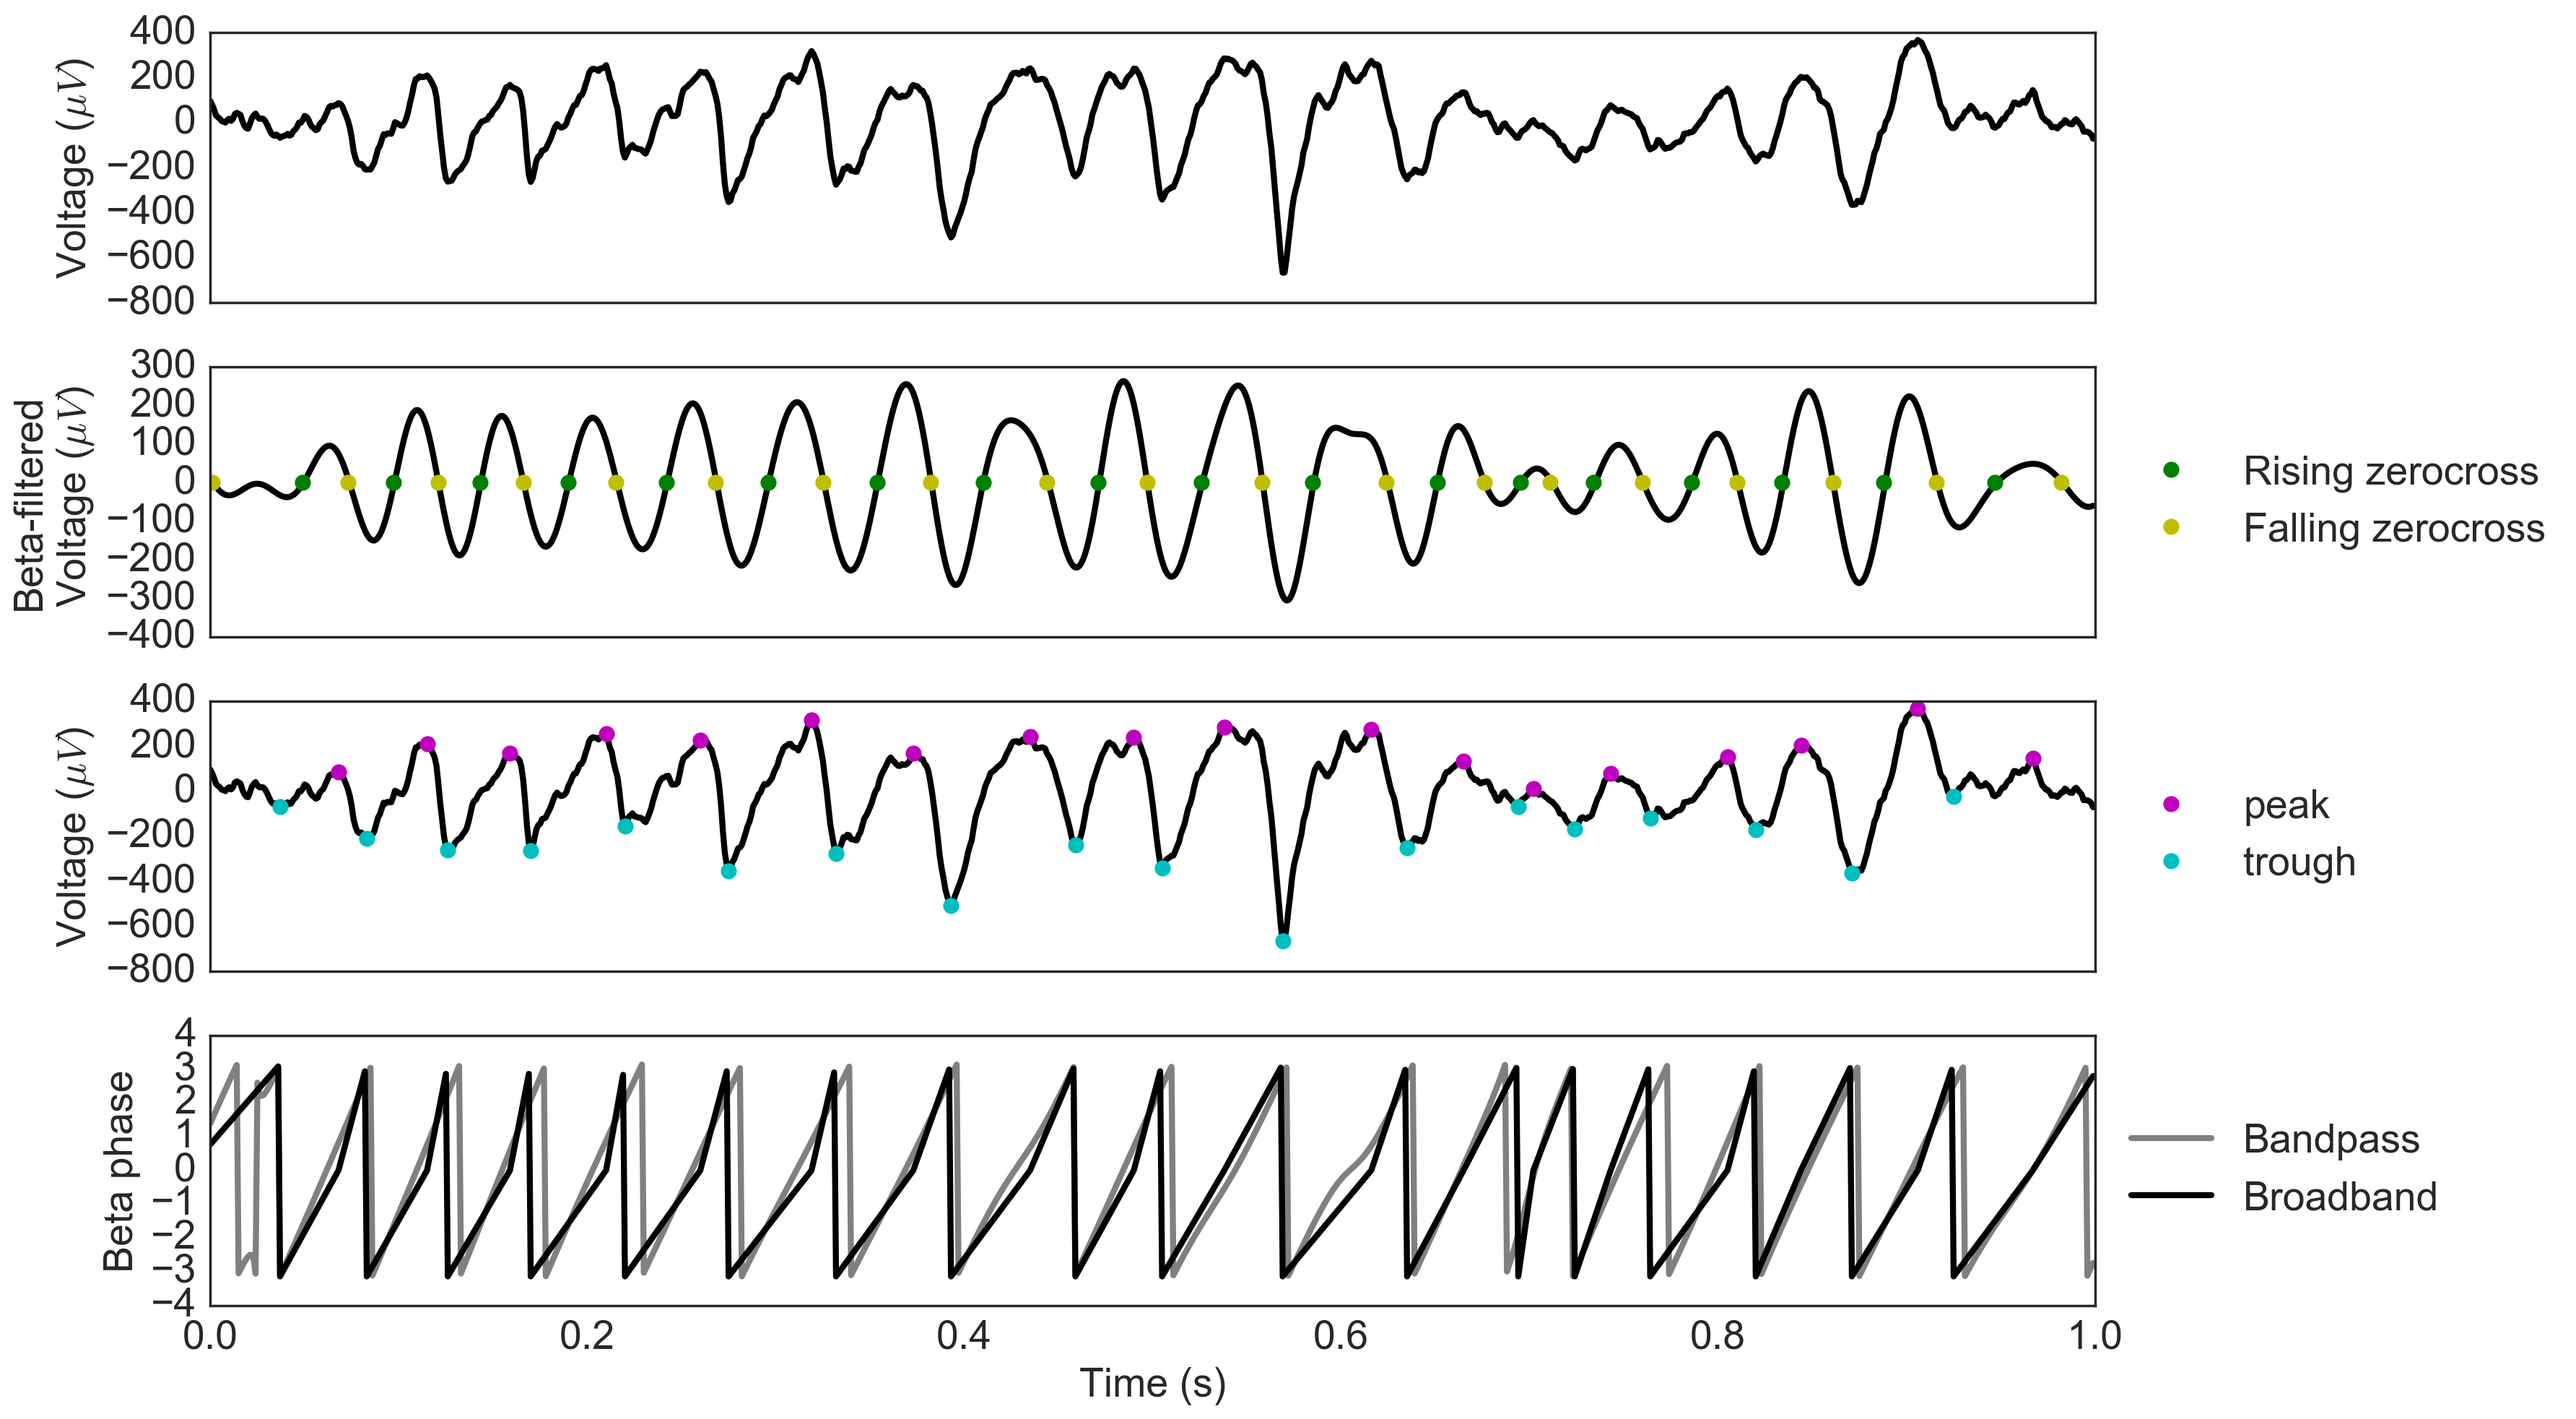

In [5]:
fig = plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(t[samps]-t[samps[0]], v[samps],'k',linewidth=3)
plt.ylabel('Voltage ($\mu V$)',size=20)
#plt.ylim((-300,700))
#plt.yticks([-300,0,700])
plt.tick_params(labelsize=20)
plt.setp( plt.gca().get_xticklabels(), visible=False)

plt.subplot(4,1,2)
plt.plot(t[samps]-t[samps[0]], vbeta[samps], 'k',linewidth=3)
plt.plot(t[zxrp] - t[samps[0]], np.zeros(len(zxrp)), 'go', ms=8,label='Rising zerocross')
plt.plot(t[zxfp] - t[samps[0]], np.zeros(len(zxfp)), 'yo', ms=8,label='Falling zerocross')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.ylabel('Beta-filtered\n Voltage ($\mu V$)',size=20)
#plt.ylim((-400,400))
#plt.yticks([-400,0,400])
plt.tick_params(labelsize=20)
plt.setp( plt.gca().get_xticklabels(), visible=False)

plt.subplot(4,1,3)
plt.plot(t[samps]-t[samps[0]], v[samps], 'k-',linewidth=3)
plt.plot(t[peaksWp]-t[samps[0]],v[peaksWp],'mo', ms=8, label='peak')
plt.plot(t[troughsWp]-t[samps[0]],v[troughsWp],'co', ms=8, label='trough')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.ylabel('Voltage ($\mu V$)',size=20)
#plt.ylim((-300,700))
#plt.yticks([-300,0,700])
plt.tick_params(labelsize=20)
plt.setp( plt.gca().get_xticklabels(), visible=False)

plt.subplot(4,1,4)
plt.plot(t[samps]-t[samps[0]], bphaH[samps], color='0.5',linewidth=3, label='Bandpass')
plt.plot(t[samps]-t[samps[0]], bphaW[samps], 'k',linewidth=3, label='Broadband')
plt.ylabel('Beta phase',size=20)
plt.xlabel('Time (s)',size=20)
#plt.ylim([-4,4])
#plt.yticks([-np.pi,0,np.pi],['$-\pi$','0','$\pi$'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()

**Raw voltage (row 1). Zero-crossings are identified in a signal bandpassed in the frequency range of interest (row 2). Peaks and troughs are then identified by finding the timepoints of maximal and minimal voltage between each extrena (row 3). Instantaneous phase is found by linear interpolation over time between peaks (phase = 0) and troughs (phase = -π,π). Note the difference between the traditional method ("bandpass", gray) and the waveform-based method ("broadband", black).**